# Windkessel

In [1]:
import numpy as np
import torch
import pandas as pd

In [2]:
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'Liberation Sans',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

In [3]:
import sys
sys.path.insert(0, './python')

In [4]:
from windkessel import model

## Проверка

In [5]:
test_model = model.WindkesselModel()

In [6]:
#test_model.R.data   = torch.ones(1, dtype=torch.float64)
#test_model.Z_0.data = torch.ones(1, dtype=torch.float64)
#test_model.C.data   = torch.ones(1, dtype=torch.float64)

#test_model.R = 1.0
#test_model.Z_0 = 1.0
#test_model.C = 1.0

In [7]:
#T = np.linspace(0.0, 10.0 * 2.0 * np.pi, 1001)

#Q_in = np.sin(T)
#test_model.set_Q_in(T, Q_in)

In [54]:
patient_id = "dataframe (3)"

In [55]:
tq = pd.read_csv(f'data/{patient_id}.csv', header = None, sep = ' ')

In [56]:
tq = tq.rename({0 :'t', 1: 'q'}, axis = 1)
tq = tq.sort_values(by=['t'])

In [57]:
T = np.array(tq['t'])
Q = np.array(tq['q'])

In [58]:
Q_in = Q*1000
test_model.set_Q_in(T, Q_in)

In [59]:
grid_dt = T[1] - T[0]

### Получение $ P(t) $ по $ Q_{in}(t) $

In [60]:
from scipy.integrate import solve_ivp

In [61]:
# dP / dt = test_model.P_rhs(t, P)

def P_rhs(t, P):
    return test_model.P_rhs(t, P)#.detach().numpy()

In [62]:
%%time
result = solve_ivp(P_rhs, (T[0], T[-1]), np.array([80.0]), t_eval = T, max_step=grid_dt)

CPU times: user 423 ms, sys: 0 ns, total: 423 ms
Wall time: 425 ms


In [63]:
P = result.y[0]

In [64]:
def plot_x_y(x, y):
    fig = plt.figure()
    ax = fig.gca()
    fig.set_figheight(12)
    fig.set_figwidth(16)
    ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
    ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')
    
    ax.plot(x, y)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')

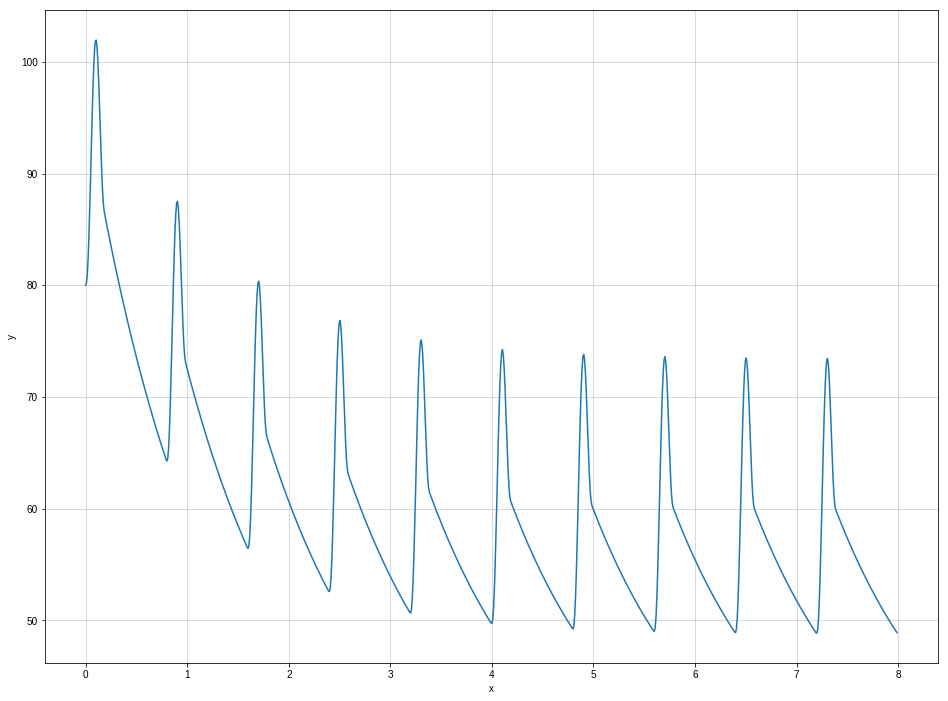

In [65]:
plot_x_y(T, P)

### Получение $ Q_{in}(t) $ по $ P(t) $

In [32]:
test_model.set_P(T, P)

In [33]:
# dQ_in / dt = test_model.Q_in_rhs(t, Q_in)

def Q_in_rhs(t, Q_in):
    return test_model.Q_in_rhs(t, Q_in)#.detach().numpy()

In [34]:
%%time
result = solve_ivp(Q_in_rhs, (T[0], T[-1]), np.array([0.0]), t_eval = T, max_step=grid_dt)

CPU times: user 123 ms, sys: 273 µs, total: 123 ms
Wall time: 122 ms


In [35]:
numerical_Q_in = result.y[0]

In [36]:
print("Error L2-norm: %.2e" % np.linalg.norm(Q_in - numerical_Q_in))
print("Error C-norm: %.2e"  % np.max(np.abs(Q_in - numerical_Q_in)))

Error L2-norm: 2.22e+01
Error C-norm: 6.75e+00


## Получение $Q_{in}(t)$ по $P(t)$ из таблички

In [37]:
patient_id = 148413

In [38]:
tp = pd.read_csv(f'data/{patient_id}.csv', header = None, sep = '; ')

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [39]:
tp = tp.rename({0 :'t', 1: 'p'}, axis = 1)
tp = tp.sort_values(by=['t'])

In [41]:
T = np.array(tp['t'])
P = np.array(tp['p'])

In [42]:
test_model.set_P(T, P)

In [43]:
# dQ_in / dt = test_model.Q_in_rhs(t, Q_in)

def Q_in_rhs(t, Q_in):
    return test_model.Q_in_rhs(t, Q_in)#.detach().numpy()

In [44]:
%%time
result = solve_ivp(Q_in_rhs, (T[0], T[-1]), np.array([0.0]), t_eval = T, max_step=grid_dt)

CPU times: user 52.6 ms, sys: 7.29 ms, total: 59.9 ms
Wall time: 72.5 ms


In [49]:
Q_in = result.y[0]

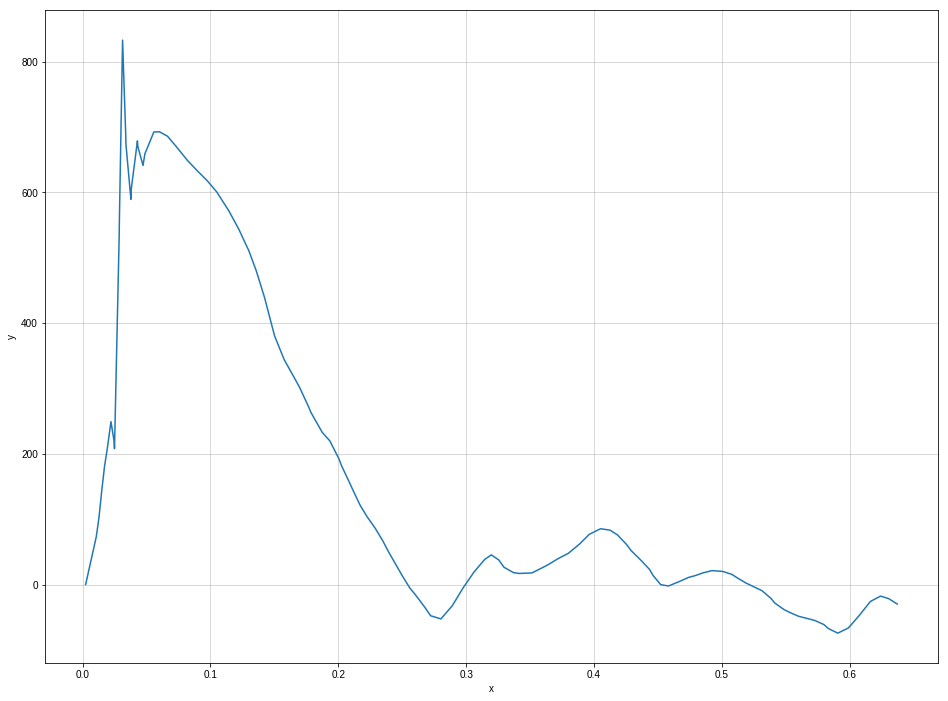

In [50]:
plot_x_y(T, Q_in)